In [72]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack, join
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import mcmc
import CL_WL_miscentering as mis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation as mass_richness
import CL_WL_fit_cluster_mass as fit
import CL_fiducial_mass_richness_relation as fiducial
import analysis_Mass_Richness_relation as analysis


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [74]:
profile_SkySim = prf.load_profile(profile_name = '/pbs/throng/lsst/users/cpayerne/CLMassDC2/data/individual_profile_cosmoDC2_gal_redMaPPer_cluster_epsilon_shape_true_z.pkl'
                              , r_in = 'radius_av', gt_in = 'gt_av', gx_in = 'gx_av', weight = 'norm_sum',
                          rmin = 1, rmax = 10)

In [75]:
filename = '../data/lens_catalog_redMaPPer.pkl'
dat_SkySim = pickle.load(open(filename, 'rb'))

In [76]:
profile_SkySim['halo_id'] = profile_SkySim['cluster_id']
profile_SkySim = join(profile_SkySim,dat_SkySim,keys='cluster_id')

In [77]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

# WL masses

In [49]:
profile_SkySim_cut = profile_SkySim

In [93]:
profile_sky_stack = prf.stacked_profile(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'richness_1',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = ['richness_1'])

covariance_sky_stack = prf.bootstrap_covariance(profile = profile_SkySim_cut,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    #ra='ra', dec='dec',
                    n_boot = 1000,
                    #                           n_jack=400,
                    z_name = 'cluster_z', obs_name = 'richness_1',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

In [94]:
def corr(cov):
    corr = np.zeros(cov.shape)
    for i in range(cov.shape[0]):
        for j in range(cov.shape[1]):
            corr[i,j] = cov[i,j]/(np.sqrt(cov[i,i]*cov[j,j]))
    return corr

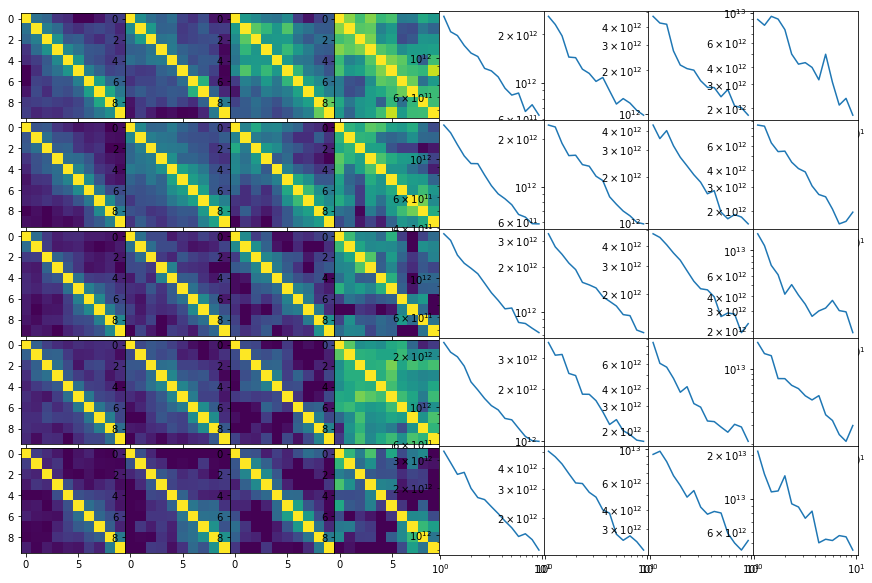

In [95]:
nz=len(Z_bin)
nobs=len(Obs_bin)
fig, ax=plt.subplots(nz, 2*nobs, figsize=(15,10),)
plt.subplots_adjust(wspace=0, hspace=0)
for i, z in enumerate(Z_bin):
    for j, obs in enumerate(Obs_bin):
        mask_z = (profile_sky_stack['z_mean'] > z[0])*(profile_sky_stack['z_mean'] < z[1])
        mask_m = (profile_sky_stack['obs_mean'] > obs[0])*(profile_sky_stack['obs_mean'] < obs[1])
        index = np.arange(len(profile_sky_stack['z_mean']))
        index_cut = index[mask_m * mask_z][0]
        Xt = covariance_sky_stack['gt_random'][index_cut]
        #for k in range(100):
        #    ax[i,j].plot(profile_stack['radius'][0], Xt[:,k], c='k')
        #    ax[i,j].set_xscale('log')
        cov=covariance_sky_stack['cov_t'][index_cut]
        rmin, rmax=1, 5.5
        indexs=np.arange(len(profile_sky_stack['radius'][0]))
        index_cuts = indexs[(profile_sky_stack['radius'][0]>rmin)*(profile_sky_stack['radius'][0]<rmax)]
        istart, iend=index_cuts[0], index_cuts[-1]
        
        cov_plot=np.array([np.array([cov[k,l] for l in np.arange(istart, iend)]) for k in np.arange(istart, iend)])
        ax[i,j].imshow(corr(cov_plot),vmin=0, vmax=1)
        #im = ax[i,j].imshow(np.log10(abs(covariance_true_stack['cov_t'][index_cut])), cmap='bwr')
        #plt.colorbar(im, ax=ax[i,j])
        ax[i,j+nobs].loglog(profile_sky_stack[index_cut]['radius'], cov.diagonal()**.5)
        #ax[i,j+nobs].loglog(profile_stack[index_cut]['radius'], shapen[index_cut]**.5)

## Fit WL masses

In [96]:
%load_ext autoreload
%autoreload 2
import CL_WL_fit_cluster_mass as fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
#fix_c_Diemer15 =       fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Diemer15')
##fix_c_Duffy08 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Duffy08')
#fix_c_Prada12 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Prada12')
#fix_c_Bhattacharya13 = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Bhattacharya13')
free_c_1h = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False, method='mcmc', is_covariance_diagonal=False)

fitting...


100%|██████████| 200/200 [00:03<00:00, 61.99it/s]


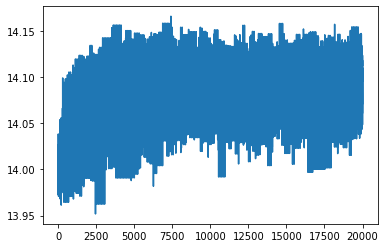

In [98]:
plt.plot(free_c_1h['chain'][0][:,0])

In [99]:
mean, err=fit.param_from_chain(free_c_1h['chain'], n_cut=19500)

In [100]:
free_c_1h['logm200_w']=mean[:,0]
free_c_1h['logm200_w_err']=err[:,0]

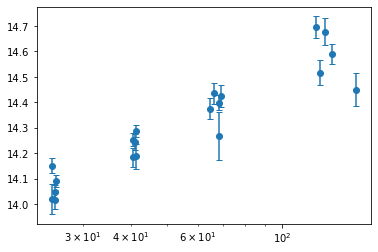

In [101]:
plt.errorbar(free_c_1h['obs_mean'], free_c_1h['logm200_w'], free_c_1h['logm200_w_err'], marker='o', fmt=' ', capsize=3)
plt.xscale('log')

In [102]:
logm=np.array(free_c_1h['logm200_w'])
logm_err=np.array(free_c_1h['logm200_w_err'])
richness_individual = np.array(free_c_1h['obs_individual'])
richness = np.array([np.mean(richness_individual[i]) for i in range(len(richness_individual))])
richness_err = np.array([np.std(richness_individual[i]) for i in range(len(richness_individual))])
z_individual = free_c_1h['z_individual']
z = np.array([np.mean(z_individual[i]) for i in range(len(z_individual))])
z_err = 0
weight_individual = None#free_c_1h['weight_per_cluster' + '_' + _5_or_10[0]]
Gamma=.7

In [103]:
WL_Mlambda = mass_richness.WL_Mass_Richness(logm=logm, logm_err=logm_err, 
                 richness=richness, richness_err=richness_err, 
                 z=z, z_err=z_err,
                 richness_individual=np.array(richness_individual), 
                 z_individual=np.array(z_individual), 
                 n_cluster_per_bin=None, weights_individual=None)#profile_sky_stack['weight_per_cluster_5'])
WL_Mlambda.set_pivot_values(analysis.z0, analysis.richness0)

In [104]:
def lnL_WL(theta, likelihood, Gamma):
    if likelihood=='classic': return WL_Mlambda.lnLikelihood_binned_classic(theta)
    if likelihood=='individual_zrichness': return WL_Mlambda.lnLikelihood_individual_zrichness(theta, Gamma)
    if likelihood=='intrinsic_scatter': return WL_Mlambda.lnLikelihood_binned_intrinsic_scatter(theta)

In [105]:
print(WL_Mlambda.n_cluster_per_bin)

[252 126  47  14 430 198  67  24 466 165  79  24 482 186  61  22 387 156
  51  16]


In [106]:
lnL_WL([14.1,-0,.75,1], 'intrinsic_scatter', 1)

21.299344763669783

In [107]:
sampler = mcmc.constraint_mcmc(lnL_WL, ('classic', .7), theta0=[14,0,1,], npath=200, nwalkers=200)

100%|██████████| 200/200 [00:02<00:00, 93.55it/s]


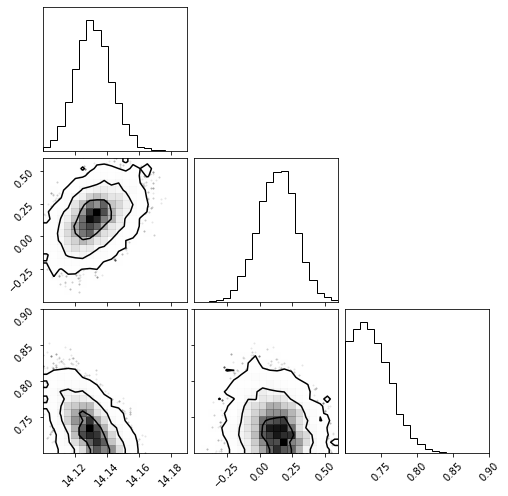

In [108]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)

sample_cut = sampler[15000:]
fig = corner.corner(
sample_cut[sample_cut[:,0]>0],
bins=20, levels=(sigma1, sigma2,sigma3),color='k',range=[(14.1,14.19), (-0.5, 0.6), (0.7, 0.9),])#(0,.4)])

In [71]:
param=np.mean(sample_cut[sample_cut[:,0]>0],axis=0)

In [ ]:
paramMC = param[0:3]

In [ ]:
paramMC=np.array([sample_cut[sample_cut[:,0]>0][:,0], sample_cut[sample_cut[:,0]>0][:,1],sample_cut[sample_cut[:,0]>0][:,2]]).T

In [ ]:
paramMC

In [ ]:
plt.figure(figsize=(10,10))
plt.errorbar(richness, 10**logm, yerr=logm_err*(10**logm), fmt=' ')
richness_axis=np.linspace(20, 200, 100)
for i, p in enumerate(paramMC):
    if i > 100: break
    plt.plot(richness_axis, 10**WL_Mlambda.mu_logM_lambda(richness_axis, 1, p), c='k', alpha=.1)
plt.loglog()